### Introduction

Extracting and quantifying chromatin patterns from routine Hematoxylin and Eosin (H&E) stained WSIs offers important insights into nuclear architecture, an important indicator of cellular state that undergoes profound alterations in various disease pathologies, particularly cancer. This analysis workflow provides an example of how Histolytics can be used to extract and quantify chromatin clumping from H&E stained images. Specifically, we will focus on the computation of the chromatin clump area and the proportion of chromatin clump area to the total nuclear area since these features are easily interpretable. In general a low chromatin clump-to-nucleus area proportion indicates dispersed chromatin, while a higher proportion can reflect increased chromatin condensation or hyperchromatism—hallmarks often associated with malignancy. If you are interested in other chromatin distribution related features, refer to the [nuclear features tutorial](../../spatial/nuclear_features/).

We will use a WSI from that we segmented in [the panoptic segmentation example](../../seg/panoptic_segmentation/) as our input data. We will also be focusing solely on the neoplastic nuclei in this tutorial.

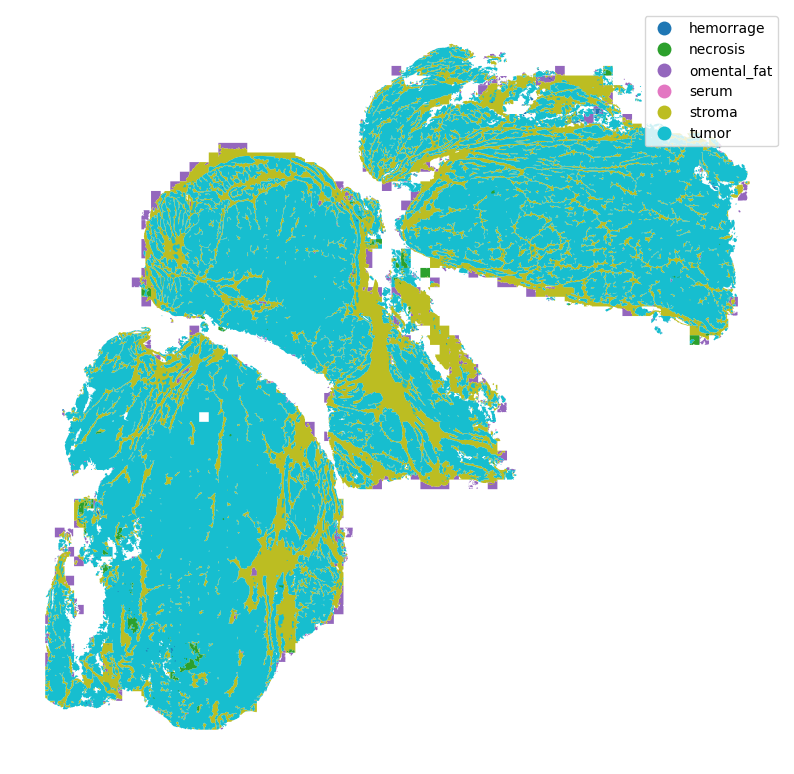

In [ ]:
import geopandas as gpd

nuc = gpd.read_parquet("/path/to/nuclei_seg.parquet")  # <- modify path
tis = gpd.read_parquet("/path/to/tissue_seg.parquet")  # <- modify path

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, legend=True)
ax.set_axis_off()

### Determining Grid for Feature Extraction

Since we will extract features from the underlying WSI rgb-data, we also need to determine a grid where the WSI will be analyzed. This grid will help us to systematically extract features at the WSI-level.

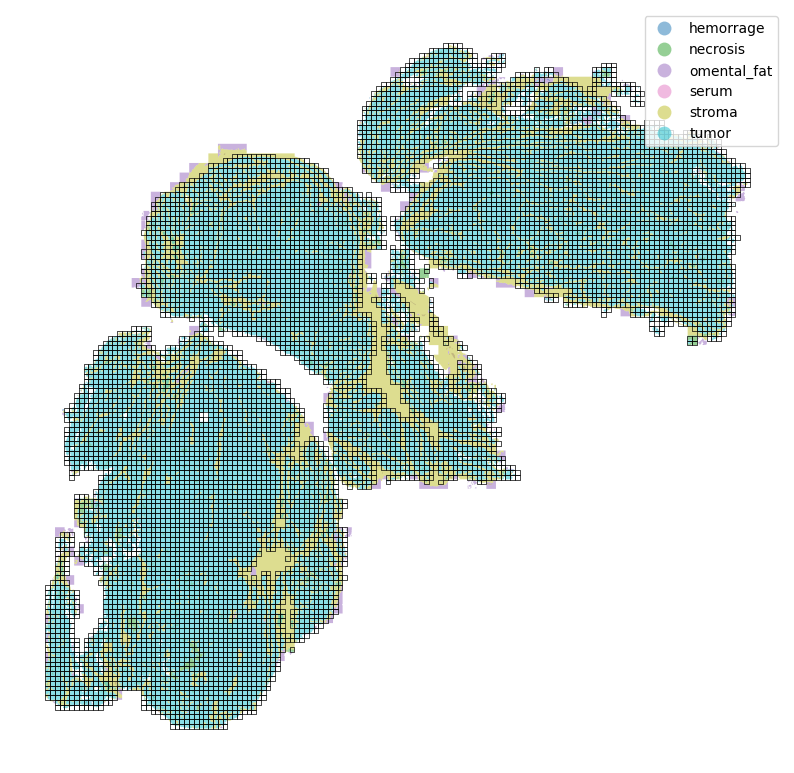

In [2]:
from histolytics.spatial_ops.rect_grid import rect_grid

# fit the grid. We'll use 512, 512 sized patches, focus only on tumor
patch_size = (512, 512)
gr = rect_grid(tis[tis["class_name"] == "tumor"], patch_size, 0)
ax = tis.plot(column="class_name", figsize=(10, 10), alpha=0.5, legend=True)
ax = gr.plot(ax=ax, edgecolor="black", facecolor="none", lw=0.5)
ax.set_axis_off()

### Initialize WSI Reader

Next, we'll initialize the WSI reader with the slide path and the desired backend. This Reader is used to access the underlying image data and perform operations at WSI-scale.

In [ ]:
from histolytics.wsi.slide_reader import SlideReader

sl_p = "/path/to/slide.tiff"  # <- modify path
reader = SlideReader(sl_p, backend="CUCIM")

# uncomment to visualize the thumbnail
# def polygon_to_xywh(polygon):
#     minx, miny, maxx, maxy = polygon.bounds
#     return (minx, miny, maxx - minx, maxy - miny)

# # convert to boxes to xywh-coords
# xywh_list = [polygon_to_xywh(geom) for geom in gr.geometry]
# thumbnail = reader.read_level(-2)
# reader.get_annotated_thumbnail(thumbnail, xywh_list)

### Initialize WSIGridProcessor

In Histolytics, the `WSIGridProcessor` is designed to facilitate the processing of whole slide images (WSIs), when the underlying image data is needed for extracting features. The class is a context manager that handles the setup and teardown of the WSI processing environment. It takes in the initialized grid, the `SlideReader` instance, and the WSI-scale nuclei and tissue segmentation maps. Also, you must pass a pipeline Callable to the processor, this pipeline will be applied to each patch of the WSI as it is processed. The pipeline function should accept the arguments `img: np.ndarray`, `label: np.ndarray`, `mask: np.ndarray`, where the img is the cropped image from the WSI, label is to cropped nuclei instance label mask from the nuclei segmentation map, and mask is the binary mask indicating the region of interest from the tissue segmentation map. We will be focusing only on neoplastic nuclei so there is no need to mask out regions in the inputs.

In [4]:
from histolytics.wsi.wsi_processor import WSIGridProcessor
from histolytics.nuc_feats.chromatin import chromatin_feats
from functools import partial

# define our pipeline
pipeline = partial(chromatin_feats, metrics=("chrom_area", "chrom_nuc_prop"))

crop_loader = WSIGridProcessor(
    slide_reader=reader,
    grid=gr,
    nuclei=nuc[nuc["class_name"] == "neoplastic"],  # use only neoplastic nuclei
    pipeline_func=pipeline,
    batch_size=8,  # use
    num_workers=8,
    pin_memory=False,
    shuffle=False,
    drop_last=False,
)

### Process the WSI

We will be using 8 cpus to loop over the grid cells. On a regular laptop this should take around two to three minutes to process. We will save the features at patch level and nuclei level. The returned batch from the data loader will contain a list of tuples where the tuple first element is the crop index and the second element is a DataFrame containing the nuclear-level features for that crop.

In [5]:
import pandas as pd
from tqdm import tqdm

crop_feats = []
nuc_feats = []
with crop_loader as loader:
    with tqdm(loader, unit="batch", total=len(loader)) as pbar:
        for batch_idx, batch in enumerate(pbar):
            crop_feats.extend(batch)  # collect the patch level dfs
            nuc_feats.append(
                pd.concat([b[1] for b in batch])
                .reset_index(drop=False)
                .rename(columns={"index": "uid"})
            )  # concatenate the nuclear feature patch dfs

nuc_feats = pd.concat(nuc_feats, axis=0)
nuc_feats.head(10)

100%|██████████| 1216/1216 [02:29<00:00,  8.14batch/s]


uid  chrom_area  chrom_nuc_prop
0  232257          37        0.948718
1  232263         232        0.720497
2  232268         335        0.865633
3  232270         327        0.918539
4  232273           0        0.000000
5  232279         545        0.718997
6  232280          41        0.976190
7  232282         143        0.910828
8  232284         221        0.969298
9  232288         225        0.937500

Let's next take area weighted mean of the `chrom_nuc_prop` and the total area for nuclei that were split by the different crops/patches. 

In [6]:
def compute_area_weighted_stats(group):
    """Compute area-weighted statistics for split nuclei."""
    total_area = group["chrom_area"].sum()

    if total_area == 0:
        return pd.Series({"chrom_nuc_prop": 0, "chrom_area": 0})

    # Area-weighted mean
    weighted_mean = (group["chrom_nuc_prop"] * group["chrom_area"]).sum() / total_area
    return pd.Series({"chrom_nuc_prop": weighted_mean, "chrom_area": total_area})


# Apply the function
nuc_feats = nuc_feats.groupby("uid").apply(
    compute_area_weighted_stats, include_groups=False
)

nuc_feats.head(10)

chrom_nuc_prop  chrom_area
uid                            
1          0.407850       239.0
2          0.482718       798.0
3          0.042517        15.0
4          0.231628       199.0
5          0.606154       360.0
6          0.620008       360.0
8          0.342438       259.0
10         0.950882       328.0
11         0.760580       834.0
12         0.298109      1071.0

### Plot the Chromatin-clump-to-nuclei-proportions

And then some plotting at nuclear level.

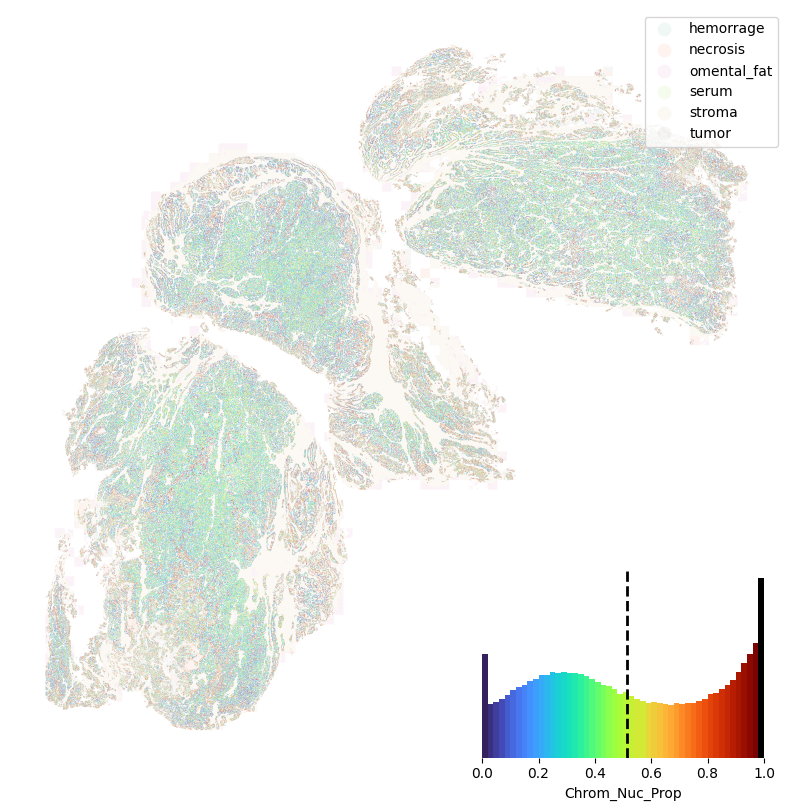

In [7]:
from histolytics.utils.plot import legendgram

neo_nuc = nuc[nuc["class_name"] == "neoplastic"]
neo_nuc = neo_nuc.merge(nuc_feats, left_index=True, right_index=True)

ax = tis.plot(
    column="class_name", figsize=(10, 10), alpha=0.1, legend=True, cmap="Set2"
)
ax = neo_nuc.plot(ax=ax, column="chrom_nuc_prop", cmap="turbo", legend=False)
ax.set_axis_off()

ax = legendgram(
    gdf=neo_nuc,
    column="chrom_nuc_prop",
    n_bins=50,
    cmap="turbo",
    ax=ax,
    loc="lower right",
)

From the plot above we can see that there are distinct regions where the chromatin-clump-to-nuclei proportion is high (red) indicating areas of nuclei with possible hyperchromatination. These potentially hyperchromatinated nuclei tend to localize often around the borders of tumor masses whereas within the solid tumor masses, the nuclei demonstrate moderate-levels of chromatin clumping (greenish/yellowish color) indicating a more heterogeneous chromatin structure.

Let's plot next the chromatin-to-nuclei-proportions at the patch level:

In [8]:
# Compute weighted column means based on DataFrame size
patch_means = []
n_nuc = []

for idx, df in crop_feats:
    if not df.empty:
        means = df.mean(numeric_only=True)
        means.name = idx

        # get also the number of nuclei so we can weight the feature values
        n_nuclei = len(df)
        patch_means.append(means)
        n_nuc.append(n_nuclei)

# Create DataFrame with means and weights
patch_means_df = pd.DataFrame(patch_means)
patch_means_df.index.name = "uid"

patch_means_df["n_nuclei"] = n_nuc

# Create weights for the rows, based on the number of nuclei in a patch
patch_means_df["weight"] = (patch_means_df["n_nuclei"] / 50).clip(upper=1.0)
patch_means_df["weighted_chrom_prop"] = (
    patch_means_df["chrom_nuc_prop"] * patch_means_df["weight"]
)
patch_means_df.head()

chrom_area  chrom_nuc_prop  n_nuclei  weight  weighted_chrom_prop
uid                                                                   
0    221.388889        0.831905        18    0.36             0.299486
1    256.204545        0.740770        44    0.88             0.651877
2    213.126316        0.572740        95    1.00             0.572740
3    217.245455        0.546525       110    1.00             0.546525
4    243.718447        0.518922       103    1.00             0.518922

In [9]:
grid_feats = gr.merge(patch_means_df, left_index=True, right_index=True)
grid_feats["geometry"] = grid_feats.geometry.boundary
grid_feats.head()

geometry  chrom_area  \
0  LINESTRING (35819 67563, 36331 67563, 36331 68...  221.388889   
1  LINESTRING (36331 67563, 36843 67563, 36843 68...  256.204545   
2  LINESTRING (36843 67563, 37355 67563, 37355 68...  213.126316   
3  LINESTRING (37355 67563, 37867 67563, 37867 68...  217.245455   
4  LINESTRING (37867 67563, 38379 67563, 38379 68...  243.718447   

   chrom_nuc_prop  n_nuclei  weight  weighted_chrom_prop  
0        0.831905        18    0.36             0.299486  
1        0.740770        44    0.88             0.651877  
2        0.572740        95    1.00             0.572740  
3        0.546525       110    1.00             0.546525  
4        0.518922       103    1.00             0.518922

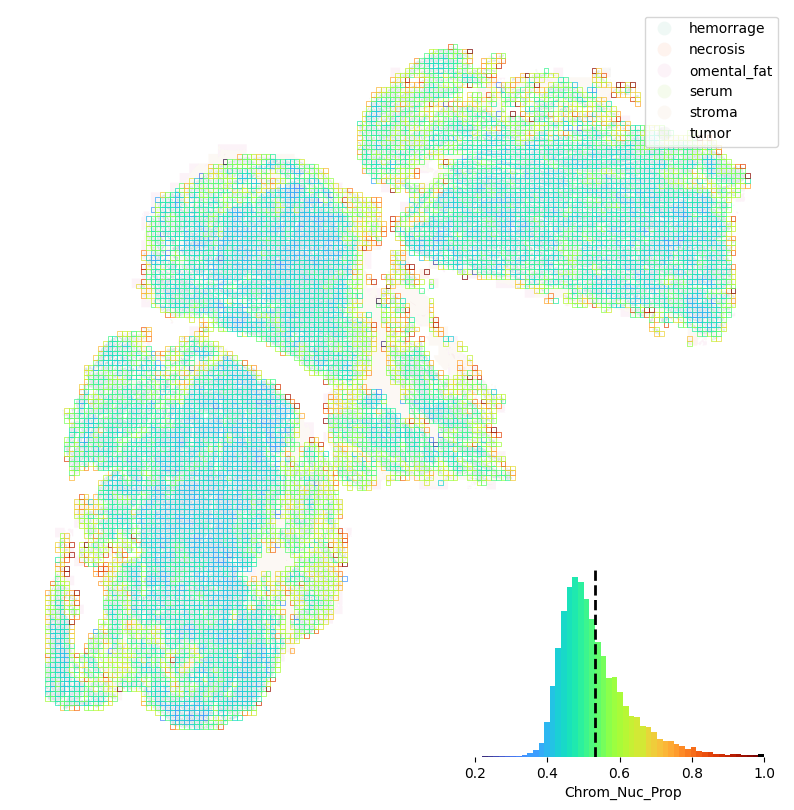

In [10]:
from histolytics.utils.plot import legendgram

ax = tis.plot(
    column="class_name", figsize=(10, 10), alpha=0.1, legend=True, cmap="Set2"
)
ax = neo_nuc.plot(ax=ax, column="class_name", legend=False, alpha=0.3)
ax = grid_feats.plot(ax=ax, column="chrom_nuc_prop", cmap="turbo", legend=False, lw=0.5)
ax.set_axis_off()

ax = legendgram(
    gdf=grid_feats,
    column="chrom_nuc_prop",
    n_bins=50,
    cmap="turbo",
    ax=ax,
    loc="lower right",
)

Here we see that most of the patches with high chromatin-to-nuclei proportions are located at the very edges of tumor regions, while patches with low proportions are found in the center. However, when we naively average the patches, we might lose a lot of information. For example, patches with only a few nuclei often stand out as having very high or very low chromatin-to-nuclei proportions. But if we consider the weighted average, taking into account the number of nuclei in each patch, we can retain more information about the distribution of chromatin states across the tissue:

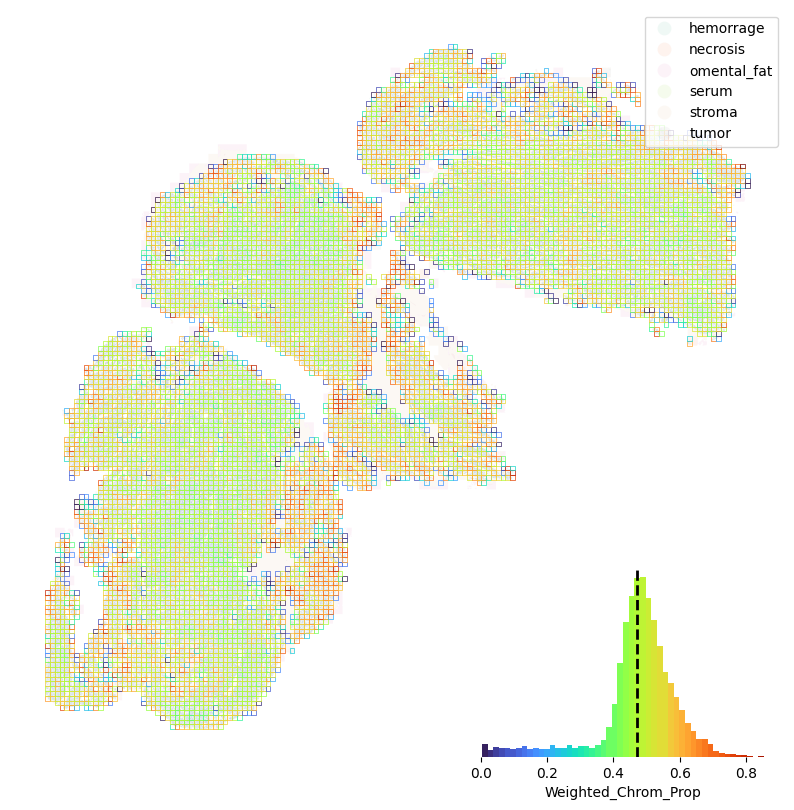

In [11]:
from histolytics.utils.plot import legendgram

ax = tis.plot(
    column="class_name", figsize=(10, 10), alpha=0.1, legend=True, cmap="Set2"
)
ax = neo_nuc.plot(ax=ax, column="class_name", legend=False, alpha=0.3)
ax = grid_feats.plot(
    ax=ax, column="weighted_chrom_prop", cmap="turbo", legend=False, lw=0.5
)
ax.set_axis_off()

ax = legendgram(
    gdf=grid_feats,
    column="weighted_chrom_prop",
    n_bins=50,
    cmap="turbo",
    ax=ax,
    loc="lower right",
)

Now this looks a bit better!

### Visualizing H&E patches

Let's now visualize some H&E crops to see what the chromatin-clumping actually looks like. Let's first select some patches with high and low chromatin clump proportions.

In [12]:
import matplotlib.pyplot as plt

grid_feats_sorted = grid_feats.sort_values("weighted_chrom_prop")
grid_feats_sorted = grid_feats_sorted[grid_feats_sorted["n_nuclei"] > 60]

low_patches = grid_feats_sorted.head(6)
high_patches = grid_feats_sorted.tail(6)

In [13]:
def polygon_to_xywh(polygon):
    """Convert polygon to xywh coordinates for slide reader."""
    minx, miny, maxx, maxy = polygon.bounds
    return (int(minx), int(miny), int(maxx - minx), int(maxy - miny))


def extract_patch_images(patches, reader):
    """Extract images from WSI for given patches."""
    images = []
    patch_info = []

    for idx, _ in patches.iterrows():
        original_geom = gr.loc[idx, "geometry"]
        x, y, w, h = polygon_to_xywh(original_geom)
        img = reader.read_region((int(x), int(y), int(w), int(h)), 0)
        images.append(img)

    return images, patch_info


# Extract images for low and high chromatin patches
low_images, low_info = extract_patch_images(low_patches, reader)
high_images, high_info = extract_patch_images(high_patches, reader)

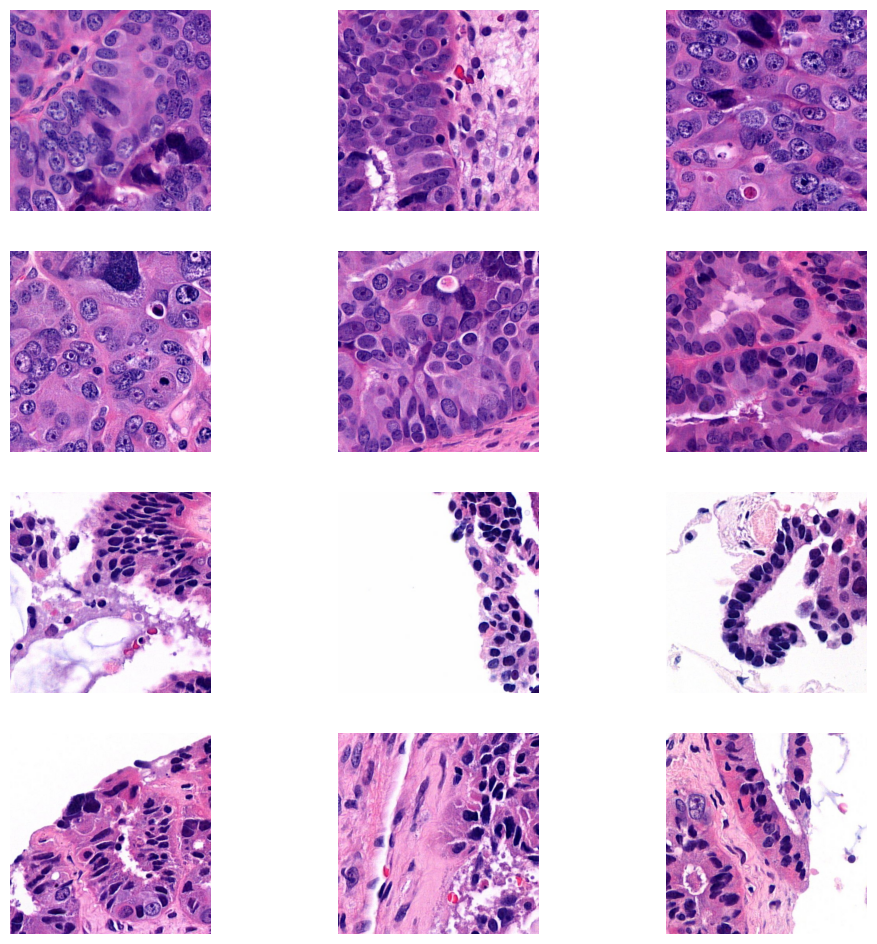

In [14]:
# Create visualization grid
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Plot low chromatin patches (top 2 rows)
for i, img in enumerate(low_images):
    row = i // 3
    col = i % 3

    ax = axes[row, col]
    ax.imshow(img)
    ax.axis("off")

# Plot high chromatin patches (bottom 2 rows)
for i, img in enumerate(high_images):
    row = 2 + i // 3
    col = i % 3

    ax = axes[row, col]
    ax.imshow(img)
    ax.axis("off")


From the above plot we see that the low chromatin-clump-to-nuclei proportion patches (two first rows) show neoplastic nuclei where the chromatin is clearly clumped and distributed in a more dispersed manner. Some of the nuclei exhibit prominent nucleoli, either single or multiple (multinucleation). In contrast, the high chromatin-clump-to-nuclei proportion patches (two last rows) exhibit a more compact chromatin pattern, with less clumping observed. The broadly distributed and dark stain of the chromatin indicate hyperchromatic neoplastic nuclei.

### Conclusions

In this tutorial, we demonstrated how to extract and quantify chromatin patterns from H&E stained WSIs using Histolytics. Specifically, we focused on the neoplastic nuclei, for which computed features such as the chromatin clump area and the proportion of chromatin clump area to the total nuclear area. We used these features to characterize the chromatin architecture of neoplastic nuclei and explored how nuclei with differences in their chromatin organization distribute within the slide.